In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [8]:
files_std = glob.glob('../../../IRL22SU/FeT_2235/*std*.txt')
files_std
samples = glob.glob('../../../IRL22SU/FeT_2235/*22*.txt')
samples
files = glob.glob('../../../IRL22SU/FeT_2235/*.txt')
files

#here is where the output will go 
path2 = '../../../IRL22SU/FeT_2235/Outputs.csv'
files

['../../../IRL22SU/FeT_2235\\0.0_std_Absorbance__0__0.txt',
 '../../../IRL22SU/FeT_2235\\0.1_std_Absorbance__0__1.txt',
 '../../../IRL22SU/FeT_2235\\0.5_std_Absorbance__0__2.txt',
 '../../../IRL22SU/FeT_2235\\1.0_std_Absorbance__0__3.txt',
 '../../../IRL22SU/FeT_2235\\10.0_std_Absorbance__0__5.txt',
 '../../../IRL22SU/FeT_2235\\223500_Absorbance__0__6.txt',
 '../../../IRL22SU/FeT_2235\\223501_Absorbance__0__7.txt',
 '../../../IRL22SU/FeT_2235\\223502_Absorbance__0__8.txt',
 '../../../IRL22SU/FeT_2235\\223503_Absorbance__0__9.txt',
 '../../../IRL22SU/FeT_2235\\223505_Absorbance__0__10.txt',
 '../../../IRL22SU/FeT_2235\\223506_Absorbance__0__11.txt',
 '../../../IRL22SU/FeT_2235\\223507_Absorbance__0__12.txt',
 '../../../IRL22SU/FeT_2235\\223508_Absorbance__0__13.txt',
 '../../../IRL22SU/FeT_2235\\223509_Absorbance__0__14.txt',
 '../../../IRL22SU/FeT_2235\\223511_Absorbance__0__15.txt',
 '../../../IRL22SU/FeT_2235\\223512_Absorbance__0__16.txt',
 '../../../IRL22SU/FeT_2235\\3.0_std_Absorb

In [9]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [2]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

NameError: name 'files' is not defined

In [1]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("")
ax.get_legend().remove()

NameError: name 'plt' is not defined

In [13]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs

,abs_562,intagration
sample,,
0.0_std_Absorbance__0__0.txt,0.301088,33.118880
0.1_std_Absorbance__0__1.txt,0.422238,46.199626
0.5_std_Absorbance__0__2.txt,0.823919,89.937096
1.0_std_Absorbance__0__3.txt,1.407996,155.369901
10.0_std_Absorbance__0__5.txt,2.816347,532.168541
223500_Absorbance__0__6.txt,0.377027,46.590825
223501_Absorbance__0__7.txt,0.330088,38.630812
223502_Absorbance__0__8.txt,0.353862,41.741860
223503_Absorbance__0__9.txt,0.370980,43.791021


EXPERIMENTAL

In [7]:
frames = []
for f in files_std:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
    df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
    df['wl'] = df.index

Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col]
    abs_562 = np.asarray(abs_562, dtype=float).ravel()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    outs = pd.DataFrame(dict)
    outs = outs.set_index('sample', drop=True)
    Frames.append(outs)

outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
outs = outs.drop('wl')
outs['conc'] = [0,.1,.5,1,1,10,3]
outs


,abs_562,intagration,conc
sample,,,
0.0_um_std_Absorbance__0__0.txt,[0.020209750994367066],2.715984,0.0
0.1_um_std_Absorbance__0__1.txt,[0.15081466871207874],16.883136,0.1
0.5_um_std_Absorbance__0__2.txt,[0.7396483088632076],80.706048,0.5
1.0_um_std_Absorbance__0__3.txt,[1.3826464845286912],151.443222,1.0
1.0_um_std_Absorbance__0__4.txt,[1.3802426461338355],151.053000,1.0
10.0_um_std_Absorbance__0__6.txt,[2.9010660299001967],523.214182,10.0
3.0_um_std_Absorbance__0__5.txt,[2.7860734943752212],378.118524,3.0


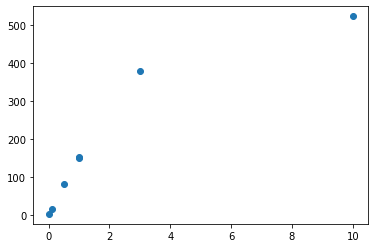

In [8]:
plt.scatter(outs['conc'], outs['intagration'])